# 1.3 Portfolio Simulation with Position Sizing

Proper portfolio simulation with:
1. **Compounding** - reinvest gains/losses into subsequent trades
2. **Position sizing** - allocate X% of current NAV per trade
3. **Correct drawdown** - measured as % decline from peak equity

Compare different position sizing strategies:
- Fixed 5%, 10%, 20%, 50% of NAV per trade
- Kelly-inspired sizing (future)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

DATA_DIR = Path('../data/earnings')
INITIAL_NAV = 10_000  # Starting capital

## 1. Load Data

In [2]:
# Load OOS predictions
oos = pd.read_parquet(DATA_DIR / 'oos_predictions.parquet')
oos['earnings_date'] = pd.to_datetime(oos['earnings_date'])

print(f"Out-of-sample predictions: {len(oos)}")
print(f"Date range: {oos['earnings_date'].min().date()} to {oos['earnings_date'].max().date()}")

Out-of-sample predictions: 60257
Date range: 2022-01-10 to 2025-12-18


## 2. Portfolio Simulation Engine

In [3]:
def simulate_portfolio(
    df: pd.DataFrame,
    initial_nav: float = 10_000,
    position_size_pct: float = 0.10,  # 10% of NAV per trade
    edge_threshold: float = 0.07,
    implied_move_multiplier: float = 1.0,  # 1.0 = optimistic, 1.3 = realistic
    spread_cost_pct: float = 0.03,
    commission_per_contract: float = 1.30,  # IBKR commission
    contracts_per_trade: int = 2,  # Straddle = 2 contracts
    max_trades_per_day: int = 5,
) -> pd.DataFrame:
    """
    Simulate portfolio with proper compounding and position sizing.
    
    Args:
        df: DataFrame with predictions (must have target_move, hist_move_mean, pred_q75)
        initial_nav: Starting capital
        position_size_pct: Fraction of current NAV to allocate per trade
        edge_threshold: Minimum edge (pred_q75 - implied) to trade
        implied_move_multiplier: Options premium over historical (1.0=optimistic, 1.3=realistic)
        spread_cost_pct: Round-trip spread cost
        commission_per_contract: IBKR commission per contract
        contracts_per_trade: Number of contracts (2 for straddle)
        max_trades_per_day: Maximum concurrent positions per day
    
    Returns:
        DataFrame with trade-by-trade results and equity curve
    """
    df = df.copy()
    
    # Calculate edge - apply implied move multiplier
    df['implied_move'] = df['hist_move_mean'] * implied_move_multiplier
    df['edge'] = df['pred_q75'] - df['implied_move']
    
    # Filter to tradeable
    df['tradeable'] = df['edge'] > edge_threshold
    
    # Sort by date and edge (best edge first)
    df = df.sort_values(['earnings_date', 'edge'], ascending=[True, False])
    
    # Limit trades per day
    df['trade_rank'] = df.groupby('earnings_date').cumcount() + 1
    df['take_trade'] = df['tradeable'] & (df['trade_rank'] <= max_trades_per_day)
    
    # Get trades only
    trades = df[df['take_trade']].copy()
    trades = trades.sort_values('earnings_date').reset_index(drop=True)
    
    if len(trades) == 0:
        return pd.DataFrame()
    
    # Commission as % of position (entry + exit)
    # Assume average position ~$5000 for commission calculation
    avg_position = 5000
    commission_pct = (commission_per_contract * contracts_per_trade * 2) / avg_position
    
    # Simulate with compounding
    nav = initial_nav
    peak_nav = initial_nav
    
    results = []
    
    for idx, row in trades.iterrows():
        # Position size based on current NAV
        position_value = nav * position_size_pct
        
        # P&L for this trade (as fraction of position)
        # Cost = implied_move + spread + commission
        total_cost = row['implied_move'] + spread_cost_pct + commission_pct
        trade_return = row['target_move'] - total_cost
        
        # Dollar P&L
        dollar_pnl = position_value * trade_return
        
        # Update NAV
        nav_before = nav
        nav = nav + dollar_pnl
        
        # Track peak for drawdown
        peak_nav = max(peak_nav, nav)
        
        # Drawdown from peak (as percentage)
        drawdown_pct = (nav - peak_nav) / peak_nav if peak_nav > 0 else 0
        
        results.append({
            'earnings_date': row['earnings_date'],
            'symbol': row['symbol'],
            'edge': row['edge'],
            'target_move': row['target_move'],
            'implied_move': row['implied_move'],
            'trade_return': trade_return,
            'position_value': position_value,
            'dollar_pnl': dollar_pnl,
            'nav_before': nav_before,
            'nav_after': nav,
            'peak_nav': peak_nav,
            'drawdown_pct': drawdown_pct,
        })
    
    return pd.DataFrame(results)

In [4]:
def compute_portfolio_metrics(results_df: pd.DataFrame, initial_nav: float) -> dict:
    """
    Compute key portfolio metrics from simulation results.
    """
    if len(results_df) == 0:
        return {}
    
    final_nav = results_df['nav_after'].iloc[-1]
    total_return = (final_nav - initial_nav) / initial_nav
    
    # Max drawdown (already computed as % from peak)
    max_drawdown = results_df['drawdown_pct'].min()
    
    # Win rate
    win_rate = (results_df['dollar_pnl'] > 0).mean()
    
    # Sharpe (annualized)
    daily_returns = results_df.groupby('earnings_date')['dollar_pnl'].sum()
    # Normalize by NAV at start of each day for proper return calculation
    daily_nav = results_df.groupby('earnings_date')['nav_before'].first()
    daily_return_pct = daily_returns / daily_nav
    
    n_days = len(daily_returns)
    n_calendar = (results_df['earnings_date'].max() - results_df['earnings_date'].min()).days
    trades_per_year = n_days * 252 / n_calendar if n_calendar > 0 else 100
    
    sharpe = 0
    if daily_return_pct.std() > 0:
        sharpe = (daily_return_pct.mean() / daily_return_pct.std()) * np.sqrt(trades_per_year)
    
    # CAGR
    years = n_calendar / 365 if n_calendar > 0 else 1
    cagr = (final_nav / initial_nav) ** (1 / years) - 1 if years > 0 else 0
    
    return {
        'n_trades': len(results_df),
        'initial_nav': initial_nav,
        'final_nav': final_nav,
        'total_return': total_return,
        'cagr': cagr,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate,
        'sharpe': sharpe,
        'calmar': cagr / abs(max_drawdown) if max_drawdown != 0 else 0,
    }

## 3. Compare Position Sizing Strategies

In [5]:
# Test different position sizes (OPTIMISTIC: 1.0x implied move)
POSITION_SIZES = [0.05, 0.10, 0.15, 0.20, 0.30, 0.50]
EDGE_THRESHOLD = 0.07  # Optimal from 1.2

all_results = {}
all_metrics = []

for pos_size in POSITION_SIZES:
    results = simulate_portfolio(
        oos,
        initial_nav=INITIAL_NAV,
        position_size_pct=pos_size,
        edge_threshold=EDGE_THRESHOLD,
        implied_move_multiplier=1.0,  # OPTIMISTIC
        spread_cost_pct=0.03,
    )
    
    if len(results) > 0:
        all_results[pos_size] = results
        metrics = compute_portfolio_metrics(results, INITIAL_NAV)
        metrics['position_size'] = pos_size
        all_metrics.append(metrics)

metrics_df = pd.DataFrame(all_metrics)
print(f"=== Position Sizing Comparison (OPTIMISTIC: 1.0x implied move, {EDGE_THRESHOLD:.0%} edge) ===\n")
print(metrics_df.to_string(index=False, formatters={
    'position_size': '{:.0%}'.format,
    'initial_nav': '${:,.0f}'.format,
    'final_nav': '${:,.0f}'.format,
    'total_return': '{:+.1%}'.format,
    'cagr': '{:+.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'win_rate': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'calmar': '{:.2f}'.format,
}))
print("\n⚠️  NOTE: These results use OPTIMISTIC 1.0x implied move assumption.")
print("See Section 8 for REALISTIC results with 1.3x implied move.")

=== Position Sizing Comparison (OPTIMISTIC: 1.0x implied move, 7% edge) ===

 n_trades initial_nav      final_nav total_return     cagr max_drawdown win_rate sharpe calmar position_size
     1277     $10,000        $42,091      +320.9%   +44.7%        -7.1%    48.4%   2.89   6.25            5%
     1277     $10,000       $169,789     +1597.9%  +107.0%       -13.8%    48.4%   2.89   7.74           10%
     1277     $10,000       $657,192     +6471.9%  +193.0%       -20.1%    48.4%   2.88   9.63           15%
     1277     $10,000     $2,443,643    +24336.4%  +310.6%       -25.9%    48.4%   2.88  12.01           20%
     1277     $10,000    $30,076,544   +300665.4%  +682.4%       -36.3%    48.4%   2.87  18.79           30%
     1277     $10,000 $2,935,182,925 +29351729.3% +2437.6%       -53.3%    48.4%   2.85  45.75           50%

⚠️  NOTE: These results use OPTIMISTIC 1.0x implied move assumption.
See Section 8 for REALISTIC results with 1.3x implied move.


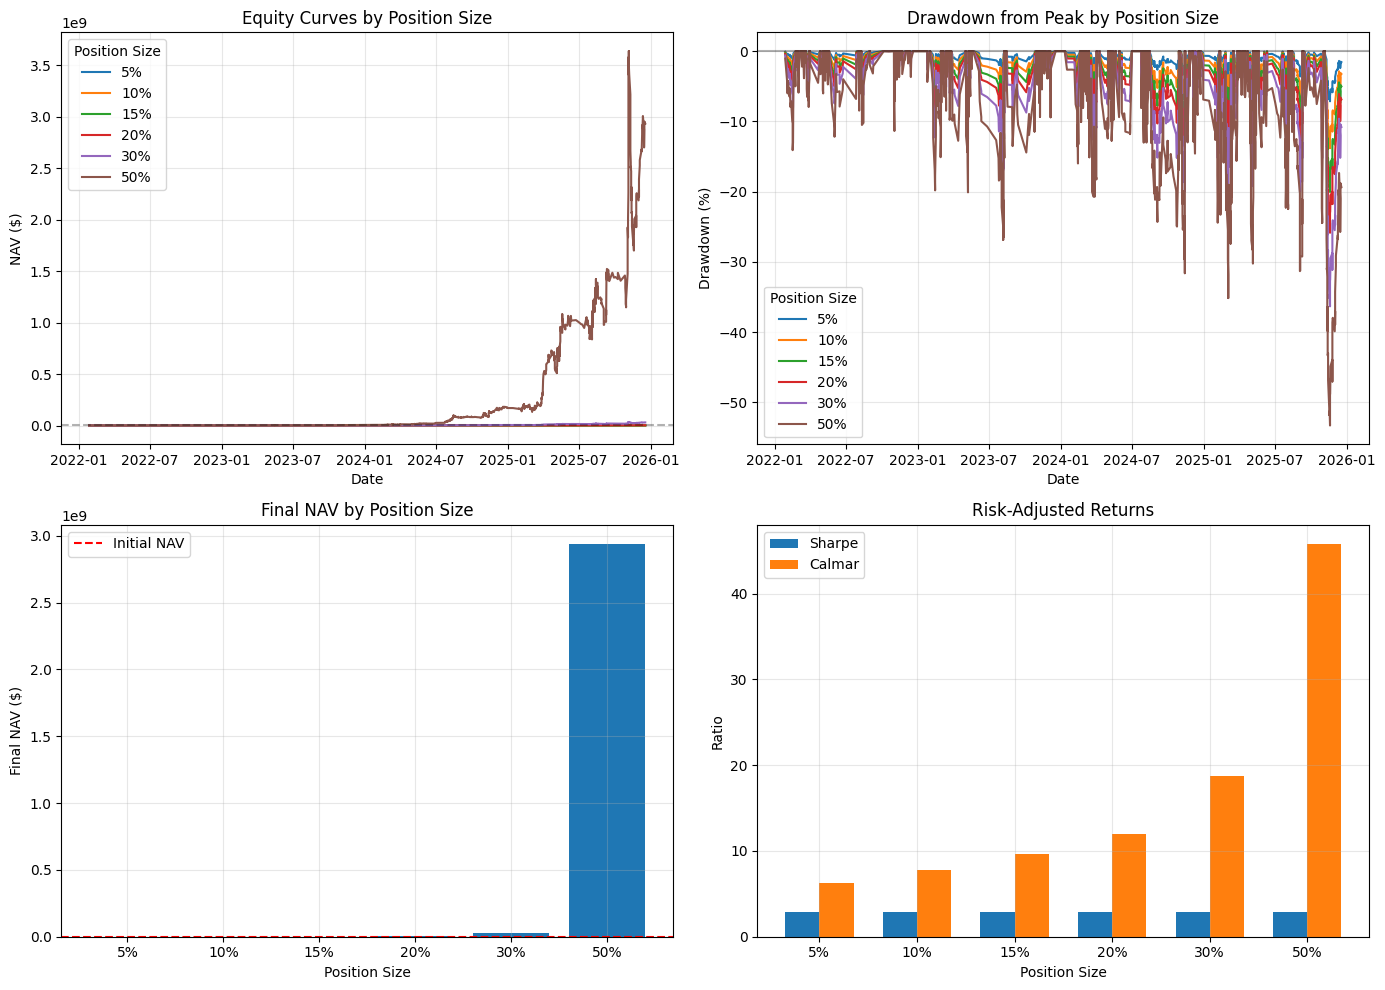

In [6]:
# Plot equity curves for different position sizes
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Equity curves
ax = axes[0, 0]
for pos_size, results in all_results.items():
    ax.plot(results['earnings_date'], results['nav_after'], label=f'{pos_size:.0%}')
ax.axhline(INITIAL_NAV, color='black', linestyle='--', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('NAV ($)')
ax.set_title('Equity Curves by Position Size')
ax.legend(title='Position Size')
ax.grid(True, alpha=0.3)

# Drawdowns
ax = axes[0, 1]
for pos_size, results in all_results.items():
    ax.plot(results['earnings_date'], results['drawdown_pct'] * 100, label=f'{pos_size:.0%}')
ax.axhline(0, color='black', linestyle='-', alpha=0.3)
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.set_title('Drawdown from Peak by Position Size')
ax.legend(title='Position Size')
ax.grid(True, alpha=0.3)

# Final NAV bar chart
ax = axes[1, 0]
ax.bar(range(len(metrics_df)), metrics_df['final_nav'])
ax.set_xticks(range(len(metrics_df)))
ax.set_xticklabels([f"{p:.0%}" for p in metrics_df['position_size']])
ax.axhline(INITIAL_NAV, color='red', linestyle='--', label='Initial NAV')
ax.set_xlabel('Position Size')
ax.set_ylabel('Final NAV ($)')
ax.set_title('Final NAV by Position Size')
ax.legend()
ax.grid(True, alpha=0.3)

# Risk-adjusted metrics
ax = axes[1, 1]
x = range(len(metrics_df))
width = 0.35
ax.bar([i - width/2 for i in x], metrics_df['sharpe'], width, label='Sharpe')
ax.bar([i + width/2 for i in x], metrics_df['calmar'], width, label='Calmar')
ax.set_xticks(x)
ax.set_xticklabels([f"{p:.0%}" for p in metrics_df['position_size']])
ax.set_xlabel('Position Size')
ax.set_ylabel('Ratio')
ax.set_title('Risk-Adjusted Returns')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(DATA_DIR / 'position_sizing_comparison.png', dpi=100)
plt.show()

## 4. Detailed Analysis of Recommended Position Size

In [7]:
# Find best position size by Sharpe or Calmar
best_sharpe_idx = metrics_df['sharpe'].idxmax()
best_calmar_idx = metrics_df['calmar'].idxmax()

print("=== Optimal Position Sizing ===")
print(f"\nBest Sharpe: {metrics_df.loc[best_sharpe_idx, 'position_size']:.0%}")
print(f"  Sharpe: {metrics_df.loc[best_sharpe_idx, 'sharpe']:.2f}")
print(f"  Max DD: {metrics_df.loc[best_sharpe_idx, 'max_drawdown']:.1%}")
print(f"  CAGR: {metrics_df.loc[best_sharpe_idx, 'cagr']:.1%}")

print(f"\nBest Calmar: {metrics_df.loc[best_calmar_idx, 'position_size']:.0%}")
print(f"  Calmar: {metrics_df.loc[best_calmar_idx, 'calmar']:.2f}")
print(f"  Max DD: {metrics_df.loc[best_calmar_idx, 'max_drawdown']:.1%}")
print(f"  CAGR: {metrics_df.loc[best_calmar_idx, 'cagr']:.1%}")

=== Optimal Position Sizing ===

Best Sharpe: 5%
  Sharpe: 2.89
  Max DD: -7.1%
  CAGR: 44.7%

Best Calmar: 50%
  Calmar: 45.75
  Max DD: -53.3%
  CAGR: 2437.6%


In [8]:
# Detailed look at 10% position size (reasonable default)
SELECTED_SIZE = 0.10
selected_results = all_results.get(SELECTED_SIZE)

if selected_results is not None:
    print(f"=== Detailed Results ({SELECTED_SIZE:.0%} position size) ===\n")
    
    # Monthly returns
    selected_results['month'] = selected_results['earnings_date'].dt.to_period('M')
    monthly = selected_results.groupby('month').agg({
        'dollar_pnl': 'sum',
        'nav_after': 'last',
        'symbol': 'count',
    }).rename(columns={'symbol': 'n_trades'})
    
    # Monthly return %
    monthly['nav_start'] = monthly['nav_after'].shift(1).fillna(INITIAL_NAV)
    monthly['return_pct'] = monthly['dollar_pnl'] / monthly['nav_start']
    
    print("Monthly Performance:")
    print(monthly[['n_trades', 'dollar_pnl', 'return_pct']].tail(12).to_string(formatters={
        'dollar_pnl': '${:+,.0f}'.format,
        'return_pct': '{:+.1%}'.format,
    }))
    
    print(f"\nProfitable months: {(monthly['dollar_pnl'] > 0).sum()} / {len(monthly)}")
    print(f"Best month: ${monthly['dollar_pnl'].max():,.0f} ({monthly['return_pct'].max():.1%})")
    print(f"Worst month: ${monthly['dollar_pnl'].min():,.0f} ({monthly['return_pct'].min():.1%})")

=== Detailed Results (10% position size) ===

Monthly Performance:
         n_trades dollar_pnl return_pct
month                                  
2025-01         5      $-874      -1.0%
2025-02        49      $+982      +1.2%
2025-03        58   $+13,732     +16.1%
2025-04        32   $+17,398     +17.6%
2025-05        59   $+11,987     +10.3%
2025-06        10    $+1,381      +1.1%
2025-07        30    $-3,749      -2.9%
2025-08        53    $+9,999      +7.9%
2025-09        22    $+6,899      +5.1%
2025-10        16    $-4,306      -3.0%
2025-11        59   $+21,993     +15.9%
2025-12        21    $+9,086      +5.7%

Profitable months: 39 / 48
Best month: $21,993 (25.7%)
Worst month: $-4,306 (-3.0%)


## 5. Sensitivity to Edge Threshold

In [9]:
# Test different edge thresholds with fixed 10% position size
EDGE_THRESHOLDS = [0.03, 0.05, 0.07, 0.08, 0.10]
FIXED_POS_SIZE = 0.10

threshold_metrics = []

for thresh in EDGE_THRESHOLDS:
    results = simulate_portfolio(
        oos,
        initial_nav=INITIAL_NAV,
        position_size_pct=FIXED_POS_SIZE,
        edge_threshold=thresh,
        spread_cost_pct=0.03,
    )
    
    if len(results) > 0:
        metrics = compute_portfolio_metrics(results, INITIAL_NAV)
        metrics['edge_threshold'] = thresh
        threshold_metrics.append(metrics)

thresh_df = pd.DataFrame(threshold_metrics)
print(f"=== Edge Threshold Sensitivity ({FIXED_POS_SIZE:.0%} position size) ===\n")
print(thresh_df.to_string(index=False, formatters={
    'edge_threshold': '{:.0%}'.format,
    'final_nav': '${:,.0f}'.format,
    'total_return': '{:+.1%}'.format,
    'cagr': '{:+.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'win_rate': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'calmar': '{:.2f}'.format,
}))

=== Edge Threshold Sensitivity (10% position size) ===

 n_trades  initial_nav final_nav total_return    cagr max_drawdown win_rate sharpe calmar edge_threshold
     3954        10000   $26,317      +163.2%  +27.9%       -37.7%    39.0%   0.79   0.74             3%
     2654        10000  $158,641     +1486.4% +101.9%       -17.4%    43.9%   2.27   5.87             5%
     1277        10000  $169,789     +1597.9% +107.0%       -13.8%    48.4%   2.89   7.74             7%
      789        10000   $82,023      +720.2%  +71.9%       -12.2%    49.8%   2.57   5.90             8%
      191        10000   $21,413      +114.1%  +22.2%        -6.3%    52.9%   1.70   3.51            10%


## 6. Risk of Ruin Analysis

In [10]:
# Check if any position size leads to ruin (NAV < 50% of initial)
RUIN_THRESHOLD = 0.50  # 50% of initial NAV

print("=== Risk of Ruin Analysis ===\n")

for pos_size, results in all_results.items():
    min_nav = results['nav_after'].min()
    min_nav_pct = min_nav / INITIAL_NAV
    hit_ruin = min_nav_pct < RUIN_THRESHOLD
    
    status = "RUIN" if hit_ruin else "OK"
    print(f"{pos_size:>5.0%}: Min NAV = ${min_nav:,.0f} ({min_nav_pct:.1%} of initial) [{status}]")

print(f"\nRuin threshold: {RUIN_THRESHOLD:.0%} of initial NAV")

=== Risk of Ruin Analysis ===

   5%: Min NAV = $9,851 (98.5% of initial) [OK]
  10%: Min NAV = $9,705 (97.0% of initial) [OK]
  15%: Min NAV = $9,560 (95.6% of initial) [OK]
  20%: Min NAV = $9,416 (94.2% of initial) [OK]
  30%: Min NAV = $9,134 (91.3% of initial) [OK]
  50%: Min NAV = $8,590 (85.9% of initial) [OK]

Ruin threshold: 50% of initial NAV


## 7. Summary & Recommendations

## 8. Realistic Assumptions (1.3x Implied Move)

**CRITICAL**: The above analysis uses `implied_move_multiplier=1.0`, assuming options cost exactly the historical move. In reality, options have a **volatility premium** - implied moves are typically 1.3-1.5x realized historical moves.

This section re-runs the portfolio simulation with realistic assumptions.

In [11]:
# Compare OPTIMISTIC vs REALISTIC implied move assumptions
print("=== Impact of Implied Move Multiplier on Portfolio Performance ===")
print("(10% position size, 7% edge threshold, 3% spread)\n")

MULTIPLIERS = [1.0, 1.1, 1.2, 1.3, 1.4]
multiplier_comparison = []

for mult in MULTIPLIERS:
    results = simulate_portfolio(
        oos,
        initial_nav=INITIAL_NAV,
        position_size_pct=0.10,
        edge_threshold=0.07,
        implied_move_multiplier=mult,
        spread_cost_pct=0.03,
    )
    
    if len(results) > 0:
        metrics = compute_portfolio_metrics(results, INITIAL_NAV)
        metrics['multiplier'] = mult
        multiplier_comparison.append(metrics)

mult_df = pd.DataFrame(multiplier_comparison)
print(mult_df.to_string(index=False, formatters={
    'multiplier': '{:.1f}x'.format,
    'final_nav': '${:,.0f}'.format,
    'total_return': '{:+.1%}'.format,
    'cagr': '{:+.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'win_rate': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
}))

print("\n" + "=" * 70)
print("KEY INSIGHT: With realistic 1.3x implied move:")
print("  - Returns drop significantly vs optimistic 1.0x assumption")
print("  - Strategy may still be profitable but with lower returns")
print("  - MUST validate with Phase 0 paper trading data")
print("=" * 70)

=== Impact of Implied Move Multiplier on Portfolio Performance ===
(10% position size, 7% edge threshold, 3% spread)

 n_trades  initial_nav final_nav total_return    cagr max_drawdown win_rate sharpe   calmar multiplier
     1277        10000  $169,789     +1597.9% +107.0%       -13.8%    48.4%   2.89 7.739395       1.0x
      974        10000   $59,405      +494.0%  +58.0%       -14.1%    47.3%   2.19 4.111830       1.1x
      722        10000   $33,538      +235.4%  +36.5%       -13.9%    46.3%   1.68 2.615009       1.2x
      538        10000   $27,055      +170.6%  +29.3%        -8.9%    47.0%   1.65 3.276930       1.3x
      412        10000   $23,016      +130.2%  +24.1%        -8.9%    49.0%   1.55 2.709939       1.4x

KEY INSIGHT: With realistic 1.3x implied move:
  - Returns drop significantly vs optimistic 1.0x assumption
  - Strategy may still be profitable but with lower returns
  - MUST validate with Phase 0 paper trading data


In [12]:
# Position sizing with REALISTIC 1.3x implied move multiplier
print("=== Position Sizing (REALISTIC: 1.3x implied move) ===\n")

REALISTIC_MULTIPLIER = 1.3
realistic_results = {}
realistic_metrics = []

for pos_size in [0.05, 0.10, 0.15, 0.20, 0.30]:
    results = simulate_portfolio(
        oos,
        initial_nav=INITIAL_NAV,
        position_size_pct=pos_size,
        edge_threshold=0.05,  # Lower threshold since fewer trades pass with 1.3x
        implied_move_multiplier=REALISTIC_MULTIPLIER,
        spread_cost_pct=0.03,
    )
    
    if len(results) > 0:
        realistic_results[pos_size] = results
        metrics = compute_portfolio_metrics(results, INITIAL_NAV)
        metrics['position_size'] = pos_size
        realistic_metrics.append(metrics)

realistic_df = pd.DataFrame(realistic_metrics)
print(realistic_df.to_string(index=False, formatters={
    'position_size': '{:.0%}'.format,
    'final_nav': '${:,.0f}'.format,
    'total_return': '{:+.1%}'.format,
    'cagr': '{:+.1%}'.format,
    'max_drawdown': '{:.1%}'.format,
    'win_rate': '{:.1%}'.format,
    'sharpe': '{:.2f}'.format,
    'calmar': '{:.2f}'.format,
}))

# Find recommended position size
if len(realistic_df) > 0:
    best_idx = realistic_df['sharpe'].idxmax()
    best = realistic_df.loc[best_idx]
    print(f"\n--- REALISTIC RECOMMENDATION ---")
    print(f"Best position size: {best['position_size']:.0%}")
    print(f"  Sharpe: {best['sharpe']:.2f}")
    print(f"  CAGR: {best['cagr']:.1%}")
    print(f"  Max DD: {best['max_drawdown']:.1%}")

=== Position Sizing (REALISTIC: 1.3x implied move) ===

 n_trades  initial_nav final_nav total_return   cagr max_drawdown win_rate sharpe calmar position_size
     1524        10000   $15,817       +58.2% +12.5%        -9.2%    41.5%   0.99   1.36            5%
     1524        10000   $24,121      +141.2% +25.4%       -17.6%    41.5%   0.99   1.44           10%
     1524        10000   $35,495      +255.0% +38.4%       -25.5%    41.5%   0.99   1.51           15%
     1524        10000   $50,444      +404.4% +51.5%       -32.7%    41.5%   1.00   1.57           20%
     1524        10000   $92,030      +820.3% +76.8%       -46.6%    41.5%   1.00   1.65           30%

--- REALISTIC RECOMMENDATION ---
Best position size: 30%
  Sharpe: 1.00
  CAGR: 76.8%
  Max DD: -46.6%


In [13]:
print("=" * 70)
print("PORTFOLIO SIMULATION SUMMARY")
print("=" * 70)

print(f"""
Initial NAV: ${INITIAL_NAV:,}
Edge threshold: {EDGE_THRESHOLD:.0%}
Spread cost: 3%

=== OPTIMISTIC RESULTS (1.0x implied move) ===
""")

# Best options (optimistic)
conservative = metrics_df[metrics_df['position_size'] == 0.05].iloc[0] if 0.05 in metrics_df['position_size'].values else None
moderate = metrics_df[metrics_df['position_size'] == 0.10].iloc[0] if 0.10 in metrics_df['position_size'].values else None

if conservative is not None:
    print(f"Conservative (5% per trade):")
    print(f"  Final NAV: ${conservative['final_nav']:,.0f}")
    print(f"  Max Drawdown: {conservative['max_drawdown']:.1%}")
    print(f"  Sharpe: {conservative['sharpe']:.2f}")

if moderate is not None:
    print(f"\nModerate (10% per trade):")
    print(f"  Final NAV: ${moderate['final_nav']:,.0f}")
    print(f"  Max Drawdown: {moderate['max_drawdown']:.1%}")
    print(f"  Sharpe: {moderate['sharpe']:.2f}")

print(f"""
=== REALISTIC RESULTS (1.3x implied move) ===
""")

# Realistic results
if len(realistic_df) > 0:
    for _, row in realistic_df.iterrows():
        if row['position_size'] in [0.05, 0.10]:
            print(f"{row['position_size']:.0%} per trade:")
            print(f"  Final NAV: ${row['final_nav']:,.0f}")
            print(f"  Max Drawdown: {row['max_drawdown']:.1%}")
            print(f"  Sharpe: {row['sharpe']:.2f}")
            print()

print("""
⚠️  CRITICAL WARNING:
- Optimistic (1.0x) results are likely OVERSTATED by 30-50%
- Use REALISTIC (1.3x) results for planning
- Validate actual implied move premium with Phase 0 data

Recommendation:
- Start with 5-10% position size for Phase 0 validation
- Use realistic 1.3x implied move assumption for planning
- Increase position size only after confirming fill rates and slippage
""")

PORTFOLIO SIMULATION SUMMARY

Initial NAV: $10,000
Edge threshold: 7%
Spread cost: 3%

=== OPTIMISTIC RESULTS (1.0x implied move) ===

Conservative (5% per trade):
  Final NAV: $42,091
  Max Drawdown: -7.1%
  Sharpe: 2.89

Moderate (10% per trade):
  Final NAV: $169,789
  Max Drawdown: -13.8%
  Sharpe: 2.89

=== REALISTIC RESULTS (1.3x implied move) ===

5% per trade:
  Final NAV: $15,817
  Max Drawdown: -9.2%
  Sharpe: 0.99

10% per trade:
  Final NAV: $24,121
  Max Drawdown: -17.6%
  Sharpe: 0.99


⚠️  CRITICAL WARNING:
- Optimistic (1.0x) results are likely OVERSTATED by 30-50%
- Use REALISTIC (1.3x) results for planning
- Validate actual implied move premium with Phase 0 data

Recommendation:
- Start with 5-10% position size for Phase 0 validation
- Use realistic 1.3x implied move assumption for planning
- Increase position size only after confirming fill rates and slippage



In [14]:
# Save best results
metrics_df.to_csv(DATA_DIR / 'position_sizing_results.csv', index=False)
print(f"Saved results to {DATA_DIR / 'position_sizing_results.csv'}")

Saved results to ../data/earnings/position_sizing_results.csv
